C:\Users\Padilla-Coreano\.conda\envs\WaveMAP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


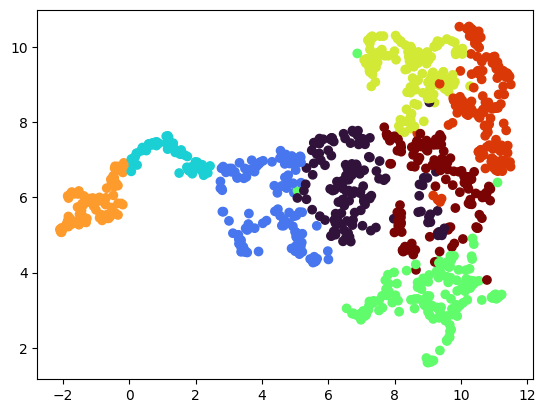

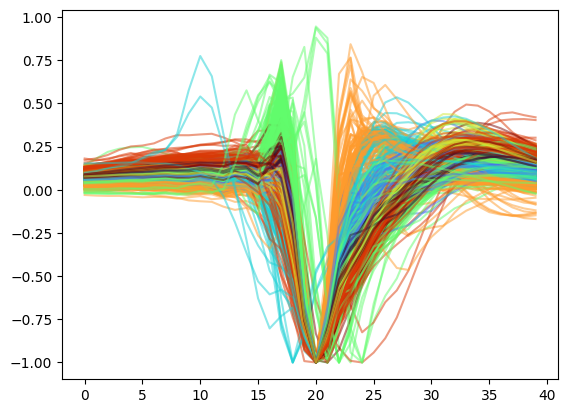

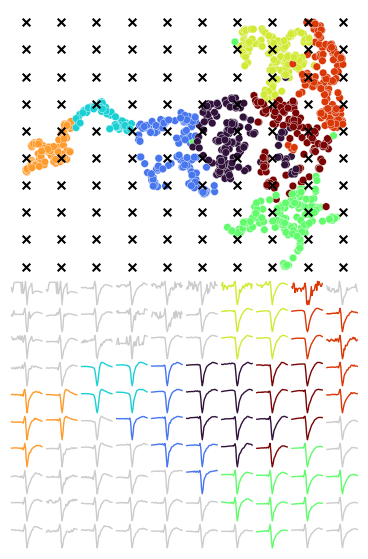

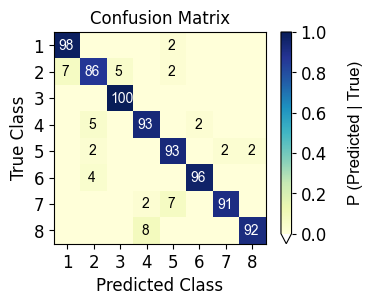

Pass `objective` as keyword args.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


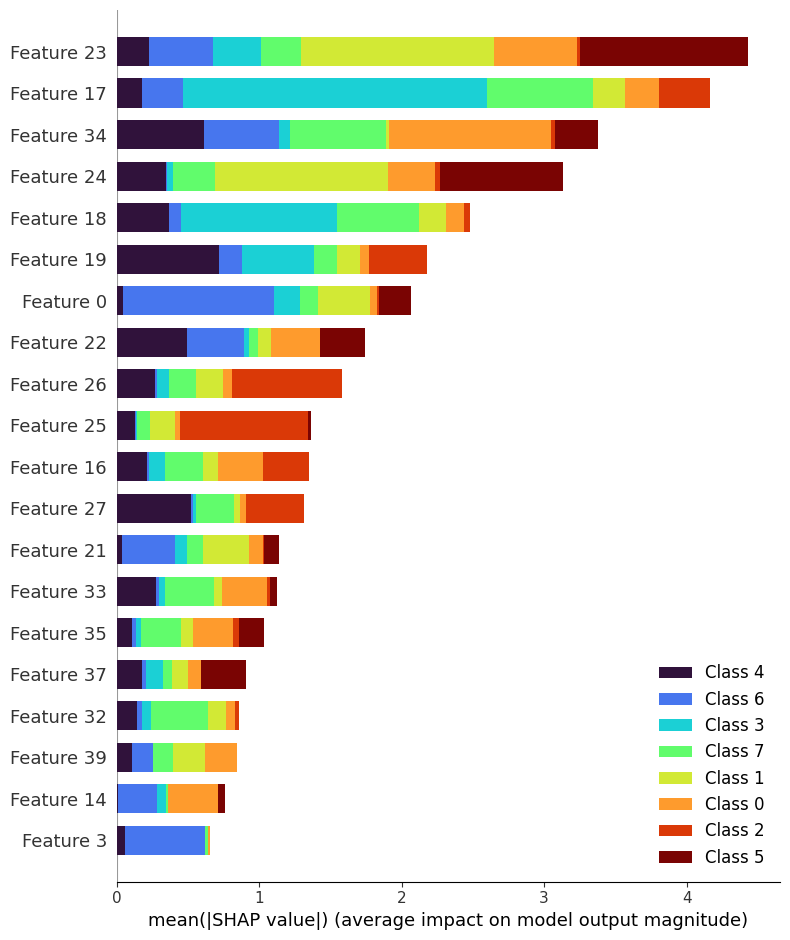

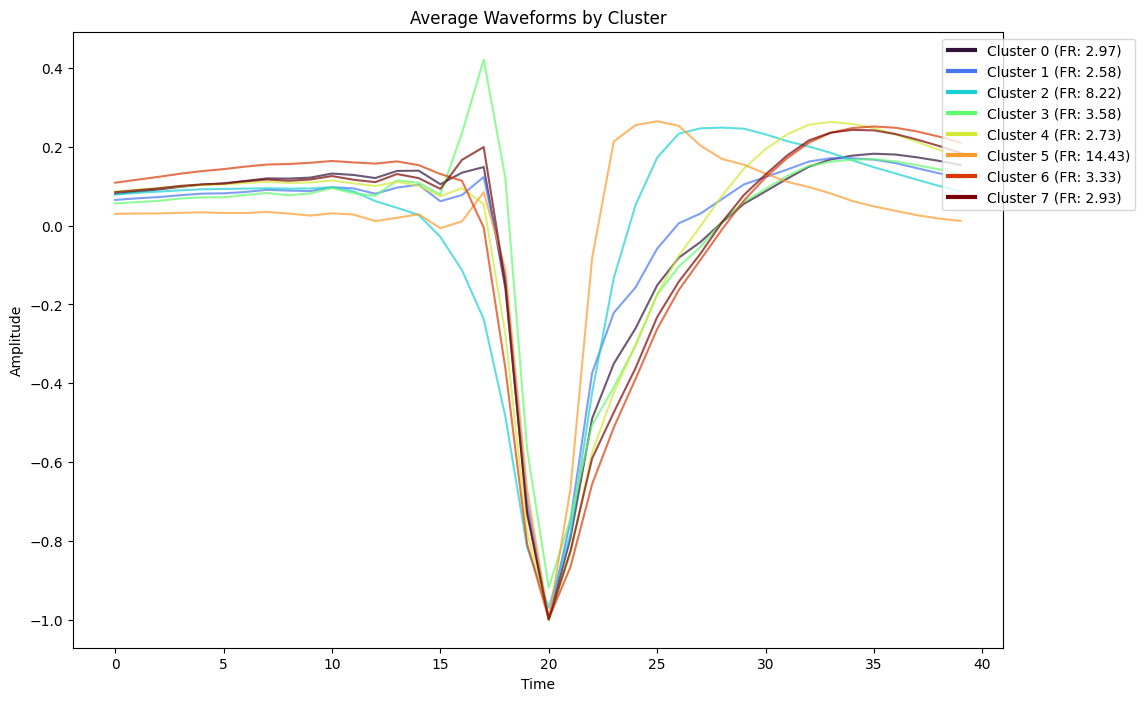

Trough-Peak duration for waveform 0: 0.75 ms
Trough-Peak duration for waveform 1: 0.65 ms
Trough-Peak duration for waveform 2: 0.40 ms
Trough-Peak duration for waveform 3: 0.75 ms
Trough-Peak duration for waveform 4: 0.65 ms
Trough-Peak duration for waveform 5: 0.25 ms
Trough-Peak duration for waveform 6: 0.75 ms
Trough-Peak duration for waveform 7: 0.70 ms


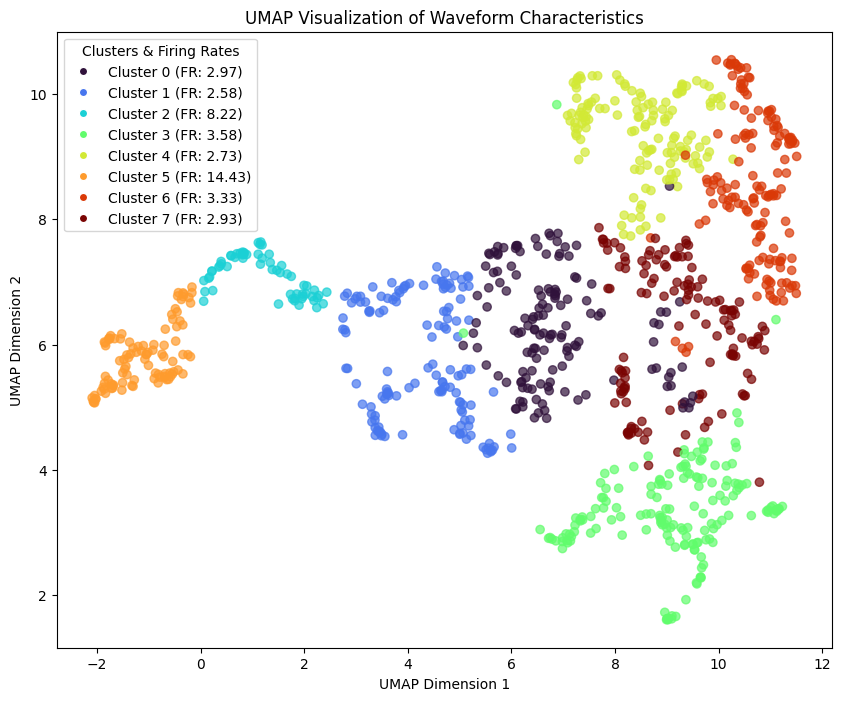

In [1]:
import concurrent.futures
import cylouvain
import matplotlib as mpl
import networkx as nx
import numpy as np
import os
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import cm
from matplotlib import pyplot as plt
from phylib.io.model import load_model
from sklearn.preprocessing import normalize
from umap import umap_ as umap
from wavemap_paper.helper_functions import plot_confusion_matrix
from wavemap_paper.helper_functions import plot_inverse_mapping
from wavemap_paper.helper_functions import RAND_STATE, set_rand_state
from wavemap_paper.helper_functions import train_gridsearch_classifier

# Constants
BASE_DIR = r'D:\pc_lab\RCE\finished_proc\phy_curation'
SAVE_PATH = r'D:\pc_lab\RCE\meanWave_clust_240723_1.npy'  # Path to save the waveform data

def process_folder(folder):
    cluster_info_path = os.path.join(folder, 'phy', 'cluster_info.tsv')
    params_path = os.path.join(folder, 'phy', 'params.py')
    recording_name = os.path.basename(folder)
    
    # Read the TSV file
    try:
        cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    except Exception as e:
        print(f"Error reading {cluster_info_path}: {e}")
        return []

    try:
        good_clusters = cluster_info[
            (cluster_info['group'] == 'good') & 
            (cluster_info['fr'] > 0.5)
        ][['cluster_id', 'fr']]
        
        # Load the TemplateModel
        model = load_model(params_path)
        
        # Initialize a list to store the mean waveforms, cluster IDs, firing rates, and recording names
        mean_waveforms = []
        cluster_ids = []
        firing_rates = []
        recording_names = []
        
        for _, row in good_clusters.iterrows():
            cluster_id = row['cluster_id']
            firing_rate = row['fr']
            
            # Get cluster spike waveforms
            waveforms = model.get_cluster_spike_waveforms(cluster_id)[:, :, 0]
            # Calculate the mean waveform and normalize it
            mean_waveform = waveforms.mean(axis=0)
            norm_mean_waveform = normalize(mean_waveform.reshape(1, -1), norm='max').squeeze()
            mean_waveforms.append(norm_mean_waveform)
            cluster_ids.append(cluster_id)
            firing_rates.append(firing_rate)
            recording_names.append(recording_name)
        
        return list(zip(mean_waveforms, cluster_ids, firing_rates, recording_names))
    
    except Exception as e:
        print(f"Error processing data in {folder}: {e}")
        return []

def main():
    # Retrieve all recording folders
    folders = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, f))]
    
    # Process each folder
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for result in executor.map(process_folder, folders):
            if result:
                results.extend(result)

    # Combine all waveforms, cluster IDs, firing rates, and recording names into a single list
    if not results:
        print("No waveforms found.")
        return

    normWFs_array = np.array([r[0] for r in results])
    cluster_ids = np.array([r[1] for r in results])
    firing_rates = np.array([r[2] for r in results])
    recording_names = np.array([r[3] for r in results])

    # Save the results to a file
    np.save(SAVE_PATH, {'waveforms': normWFs_array, 'cluster_ids': cluster_ids, 'firing_rates': firing_rates, 'recording_names': recording_names})

if __name__ == "__main__":
    main()

# Load the saved data
SAVED_PATH = r"D:\pc_lab\RCE\meanWave_clust_240723_1.npy"  # Created by iterating through every recording on external hard drive (Cyborg)
data = np.load(SAVED_PATH, allow_pickle=True).item()
# Load normWFs directly from the saved data
normWFs = data['waveforms']
cluster_ids = data['cluster_ids']

# Identify the rows that contain 1 in normWFs
rows_with_1 = np.any(normWFs == 1, axis=1)

# Multiply the identified rows by -1 to apply the necessary transformation
normWFs[rows_with_1] *= -1

set_rand_state(RAND_STATE)

reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)
mapper = reducer.fit(normWFs)

G = nx.from_scipy_sparse_array(mapper.graph_)

clustering = cylouvain.best_partition(G, resolution = 2)
clustering_solution = list(clustering.values())

embedding = reducer.fit_transform(normWFs)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")
colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
umap_df['cluster_color'] = [colors[i] for i in clustering_solution]
plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),
marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

f,arr = plt.subplots(1)

for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(umap_df['waveform'].tolist()[i],c=umap_df['cluster_color'].tolist()[i],alpha=0.5)

umap_df.to_csv('umap_df.csv')

plot_inverse_mapping(reducer, umap_df)

umap_model, conf_mat = train_gridsearch_classifier(umap_df)

plot_confusion_matrix(conf_mat,umap_df)
plt.title("Confusion Matrix")
plt.show()

xgbModel = xgb.XGBClassifier(umap_model.best_params_)
xgbModel.fit(umap_df['waveform'].tolist(),umap_df['cluster_id'].tolist())
explainer = shap.TreeExplainer(xgbModel)

umap_cmap = mpl.colors.ListedColormap(colors, name='umap_cmap')
shap_values = explainer.shap_values(umap_df['waveform'].tolist())
shap.summary_plot(shap_values, color = umap_cmap)

# Create a copy of umap_df
umap_df_detail = umap_df.copy()

# Append firing rates, recording names, and cluster_ids (renamed to unit_id)
umap_df_detail['firing_rate'] = data['firing_rates']
umap_df_detail['recording_name'] = data['recording_names']
umap_df_detail['unit_id'] = data['cluster_ids']

# Display the updated DataFrame
umap_df_detail.to_csv('umap_df_detail.csv')

# Select only the columns that should be averaged
columns_to_average = ['x', 'y', 'firing_rate']
waveform_means = umap_df_detail.groupby('cluster_id')['waveform'].apply(lambda x: np.mean(np.vstack(x), axis=0))

# Group by cluster_id and calculate the mean for the selected columns
cluster_averages = umap_df_detail.groupby('cluster_id')[columns_to_average].mean()

# Include the averaged waveforms
cluster_averages['waveform'] = waveform_means

# If cluster_color should be included, it can be taken from one of the rows for each cluster_id
cluster_colors = umap_df_detail.groupby('cluster_id')['cluster_color'].first()

# Combine the averaged DataFrame with the cluster_colors
cluster_averages['cluster_color'] = cluster_colors

# Reset the index if you want cluster_id to be a column
cluster_averages.reset_index(inplace=True)

# Display the resulting DataFrame
cluster_averages

cluster_averages.to_csv('cluster_averages.csv')

# Plot the waveforms from cluster_averages
plt.figure(figsize=(12, 8))

# Store line objects to create custom legend
lines = []

# Iterate over each row to plot the waveform and prepare legend entries
legend_entries = []
for _, row in cluster_averages.iterrows():
    line, = plt.plot(row['waveform'], color=row['cluster_color'], alpha=0.7)
    lines.append(line)
    legend_entries.append(f"Cluster {row['cluster_id']} (FR: {row['firing_rate']:.2f})")

# Adding the legend with thicker lines
plt.legend([plt.Line2D([0], [0], color=line.get_color(), linewidth=3) for line in lines], legend_entries, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('Average Waveforms by Cluster')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Count the occurrences of each cluster_id
cluster_id_counts = umap_df['cluster_id'].value_counts()

# Display the result
cluster_id_counts

def calc_trough_to_peak_duration(waveform):
    """
    Calculate the trough to peak duration in milliseconds.
    
    Parameters:
    waveform (array): The waveform array.
    
    Returns:
    float: Trough to peak duration in milliseconds.
    """
    # Find the index of the most negative value (trough)
    trough_index = np.argmin(waveform)
    
    # Find the index of the most positive value (peak) after the trough
    peak_index = np.argmax(waveform[trough_index:]) + trough_index
    
    # The duration is the difference between the peak and trough indices
    duration_samples = peak_index - trough_index
    
    # Convert the duration from samples to milliseconds
    duration_ms = duration_samples * 0.00005 * 1000  # 0.00005 seconds per sample
    
    return duration_ms

# Calculate and print spike durations
for i, waveform in enumerate(cluster_averages['waveform']):
    duration = calc_trough_to_peak_duration(waveform)
    print(f"Trough-Peak duration for waveform {i}: {duration:.2f} ms")
    
umap_df.to_pickle('umap_df.pkl')
umap_df_detail.to_pickle('umap_df_detail.pkl')

# Create a color map
cmap = plt.get_cmap("turbo")
colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

# Plotting the UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_df['x'], umap_df['y'], marker='o', c=umap_df['cluster_id'], cmap='turbo', alpha=0.7)
plt.title('UMAP Visualization of Waveform Characteristics')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Adding a legend for each cluster with firing rates
# Assume `cluster_averages` dataframe exists with `cluster_id` and `firing_rate`
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=6) 
                  for c in colors]
legend_labels = [f'Cluster {i} (FR: {row["firing_rate"]:.2f})' for i, row in cluster_averages.iterrows()]
plt.legend(handles=legend_handles, labels=legend_labels, title="Clusters & Firing Rates")

plt.show()